In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import statsmodels.graphics.tsaplots as sgt
import random

from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

In [2]:
random.seed(7)

In [3]:
df = pd.read_csv('../attributes_dataset/max_temp.csv')
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.set_index('date', inplace=True)
df.columns = ['y']
df.head()

,y
date,
2016-01-01,27.6
2016-01-02,28.0
2016-01-03,27.9
2016-01-04,27.4
2016-01-05,27.0


# Convert Dataframe to Array

In [4]:
def df_to_array(df, window_size):
    df_y_np = df.y.to_numpy()
    df_index_np = df.index.to_numpy()
    
    x = []
    y = []
    date = []
    for i in range(len(df_index_np) - window_size):
        row = [[a] for a in df_y_np[i:i+window_size]]
        x.append(row)
        label = df_y_np[i+window_size]
        y.append(label)
        index = df_index_np[i+window_size]
        date.append(index)
        
    return np.array(x), np.array(y), np.array(date)

# Configure Batch Size

In [5]:
WINDOW_SIZE = 20

# Split the Data

In [6]:
train_ratio = int(len(df) * 0.8)
test_ratio = train_ratio + int(len(df) * 0.1)

dtrain, dval, dtest = df.iloc[:train_ratio], df.iloc[(train_ratio - WINDOW_SIZE):test_ratio], df.iloc[(test_ratio - WINDOW_SIZE):]

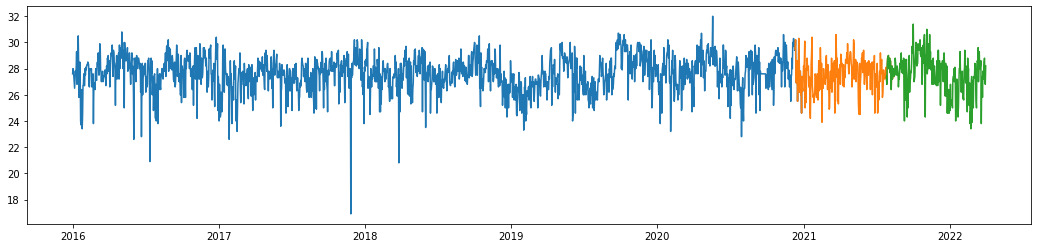

In [7]:
plt.figure(figsize=(18,4))
plt.plot(dtrain)
plt.plot(dval)
plt.plot(dtest)

# Standarization for data train

In [8]:
dev_val = dtrain.std()[0]
mean_val = dtrain.mean()[0]

def make_std(data):
    data_std = data    
    data_std = (data_std-mean_val)/dev_val
    
    return data_std

In [9]:
dtrain_std = make_std(dtrain)

In [10]:
dval_std = make_std(dval)

In [11]:
dtest_std = make_std(dtest)

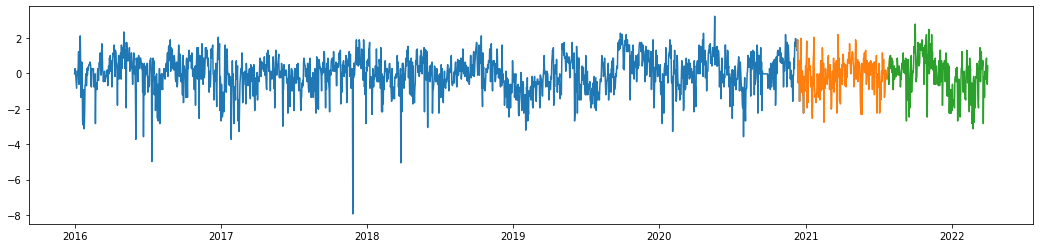

In [12]:
plt.figure(figsize=(18,4))
plt.plot(dtrain_std)
plt.plot(dval_std)
plt.plot(dtest_std)

# De-standarization Function

In [13]:
def de_std(df):
    column = ['Predictions', 'Actuals']
    for index, row in df.iterrows():
        for col in column:
            val = df.loc[index, col]
            df.loc[index, col] = (dev_val * val) + mean_val        

## Get x and y values

In [14]:
X_train, y_train, date_train = df_to_array(dtrain_std, WINDOW_SIZE)
X_val, y_val, date_val = df_to_array(dval_std, WINDOW_SIZE)
X_test, y_test, date_test = df_to_array(dtest_std, WINDOW_SIZE)

# Creating the Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import clone_model

In [16]:
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE,1)))
model1.add(LSTM(128))
model1.add(Dense(64, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________


### Saving the Model

In [17]:
cp = ModelCheckpoint('LSTM_models/model_cp_ts/', save_best_only=True)

In [18]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
%%time
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp])

Epoch 1/100
55/57 [===========================>..] - ETA: 0s - loss: 0.9337 - root_mean_squared_error: 0.9663

INFO:tensorflow:Assets written to: LSTM_models/model_cp_ts\assets


INFO:tensorflow:Assets written to: LSTM_models/model_cp_ts\assets


57/57 [==============================] - 22s 314ms/step - loss: 0.9238 - root_mean_squared_error: 0.9611 - val_loss: 0.7934 - val_root_mean_squared_error: 0.8908
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 0.8124 - root_mean_squared_error: 0.9013

# Load the Model

In [ ]:
def execute_forecast(pred, actual, date):
    df_result = pd.DataFrame(data={'date': date, 'Predictions': pred, 'Actuals': actual})
    df_result.set_index('date', inplace=True)
    
    de_std(df_result)
    
    plt.figure(figsize=(18,8))
    plt.plot(df_result['Predictions'], 'b')
    plt.plot(df_result['Actuals'], 'r:')
    plt.show()
    
    MAE = mean_absolute_error(df_result['Actuals'], df_result['Predictions'])
    RMSE = sqrt(mean_squared_error(df_result['Actuals'], df_result['Predictions']))

    print(f'Mean Absolute Error is\t\t: {MAE}')
    print(f'Root Mean Squared Error is\t: {RMSE}')
    
    return df_result, MAE, RMSE

## Train Results

In [ ]:
train_prediction = model1.predict(X_train).flatten()

In [ ]:
train_df, train_MAE, train_RMSE = execute_forecast(train_prediction, y_train, date_train)

## Validation Results

In [ ]:
val_prediction = model1.predict(X_val).flatten()

In [ ]:
val_df, val_MAE, val_RMSE = execute_forecast(val_prediction, y_val, date_val)

# updating data validation to model

## Test Results

In [ ]:
test_prediction = model1.predict(X_test).flatten()

In [ ]:
test_df, test_MAE, test_RMSE = execute_forecast(test_prediction, y_test, date_test)

In [ ]:
temp_mod = load_model('LSTM_models/model_cp_val/')

In [ ]:
tp1 = temp_mod.predict(X_test).flatten()

In [ ]:
t_df, t_MAE, t_RMSE = execute_forecast(tp1, y_test, date_test)

# k-period forecasting

In [ ]:
def one_step_forecast(model, X):
    X_val = np.array(X)
    result = model.predict(X_val).flatten()
    X_val_update = []
    
    for lags in X_val:
        lags_update = []
        
        for value in lags:
            lags_update.append(value)
        
        lags_update.append(result)
        lags_update = lags_update[1:]
        
        X_val_update.append(lags_update)
    
    return result, np.array(X_val_update)

In [ ]:
def LSTM_forecast(model, period, x_input):
    x_input = [x_input]
    final_result = []
    iteration = 0
    while iteration < period:
        result, x_input = one_step_forecast(model, x_input)
        final_result.append(result[0])
        iteration += 1
    return np.array(final_result), x_input

In [ ]:
def get_period_forecast(model, X, period, date, y_act=[]):
    res = []
    pred_date = []
    for i in np.arange(0, len(X), period):
        X_start = X[i]
        result, __ = LSTM_forecast(model, period=period, x_input=X_start)
        
        ## updating model
        if len(y_act) > 0:
            for prd in range(0,period):
                if (i+prd) < len(X):
                    X_up = np.reshape(X[i+prd], (1, X.shape[1], X.shape[2]))
                    y_up = np.reshape(y_act[i+prd], (1,))
                    print(f"({i+prd}/{len(X)-1}) updating {date[i+prd]} into model")
                    model.fit(X_up, y_up, epochs=1)
                    
        res.append(result)
        pred_date.append(date[i])
    return np.array(res), np.array(pred_date)

In [ ]:
def collect_k_res(k_res, length):
    res_val = []
    counter = 0
    for pred in k_res:
        for val in pred:
            if counter < length:
                res_val.append(val)
            counter += 1
    return np.array(res_val)

In [ ]:
def period_forecast(model, period, X, y, date):
    k_res, k_date = get_period_forecast(model, X, period, date, y_act=y)
    k_res_val = collect_k_res(k_res, len(X))
    return k_res_val

In [ ]:
sc1_model = load_model('LSTM_models/model_cp_val/')

In [ ]:
scene1_forecast = period_forecast(sc1_model, period=1, X=X_test, y=y_test, date=date_test)

In [ ]:
scene1_forecast_df, scene1_forecast_MAE, scene1_forecast_RMSE = execute_forecast(scene1_forecast, y_test, date_test)

In [ ]:
#1.308950840612178

In [ ]:
sc2_model = load_model('LSTM_models/model_cp_val/')

In [ ]:
scene2_forecast = period_forecast(sc2_model, period=3, X=X_test, y=y_test, date=date_test)

In [ ]:
scene2_forecast_df, scene2_forecast_MAE, scene2_forecast_RMSE = execute_forecast(scene2_forecast, y_test, date_test)

In [ ]:
sc3_model = load_model('LSTM_models/model_cp_val/')

In [ ]:
scene3_forecast = period_forecast(sc3_model, period=7, X=X_test, y=y_test, date=date_test)

In [ ]:
scene3_forecast_df, scene3_forecast_MAE, scene3_forecast_RMSE = execute_forecast(scene3_forecast, y_test, date_test)

In [ ]:
# 1.4463164142344496

# Load Existing Data

# Plot Final Results